In [1]:
import math
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import ExactMolWt, HeavyAtomMolWt
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from data import PolarisDataset
import torch
from collections import Counter
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol

In [2]:
tgts = ['MLM', 'HLM', 'MDR1-MDCKII', 'LogD', 'KSOL']
tgt = "MLM" #['MLM', 'HLM', 'MDR1-MDCKII', 'LogD', 'KSOL']

In [3]:
train_datasets = {}
test_datasets = {}
for tgt in tgts:
    train_datasets[tgt] =  PolarisDataset(root="./dataset", task=tgt, train=True, force_reload=True)
    test_datasets[tgt] = PolarisDataset(root="./dataset", task=tgt, train=False, force_reload=True)

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [4]:
for tgt in tgts:
    print("Target: ", tgt)
    train_dataset = train_datasets[tgt]
    print("Train size: ",len(train_dataset))
    y_values = [data.y for data in train_dataset]

    print("min - avg - max")
    min = np.min(y_values)
    avg = np.average(y_values)
    max = np.max(y_values)
    print(str(min) + " " +"{:.2f}".format(avg)+ " " + str(max))
    print("------")

    test_dataset = test_datasets[tgt]
    print("Test size: ", len(test_dataset))

    y_values = [data.y for data in test_dataset]
    print("min - avg - max")
    min = np.min(y_values)
    avg = np.average(y_values)
    max = np.max(y_values)
    print(str(min) + " " +"{:.2f}".format(avg)+ " " + str(max))
    print("--------------------")

Target:  MLM
Train size:  303
min - avg - max
0.0 176.90 2380.0
------
Test size:  106
min - avg - max
0.47712126 1.93 3.0374265
--------------------
Target:  HLM
Train size:  301
min - avg - max
0.0 124.25 1620.0
------
Test size:  112
min - avg - max
0.845098 2.46 2.60206
--------------------
Target:  MDR1-MDCKII
Train size:  425
min - avg - max
0.0 4.65 35.7
------
Test size:  122
min - avg - max
-0.26280737 2.16 3.2966652
--------------------
Target:  LogD
Train size:  352
min - avg - max
-0.7 2.21 4.5
------
Test size:  126
min - avg - max
-1.2620127 0.80 1.55145
--------------------
Target:  KSOL
Train size:  365
min - avg - max
2.0 212.76 398.0
------
Test size:  126
min - avg - max
0.3 1.96 4.3
--------------------


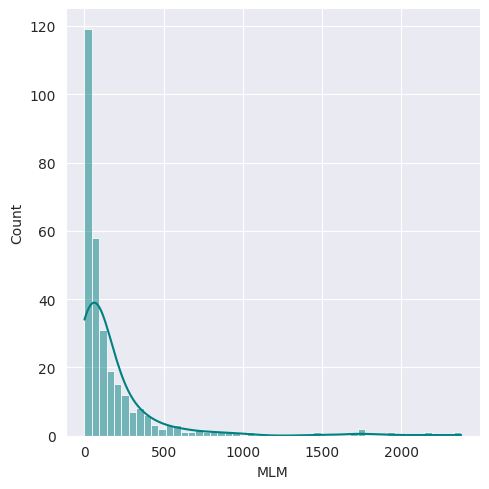

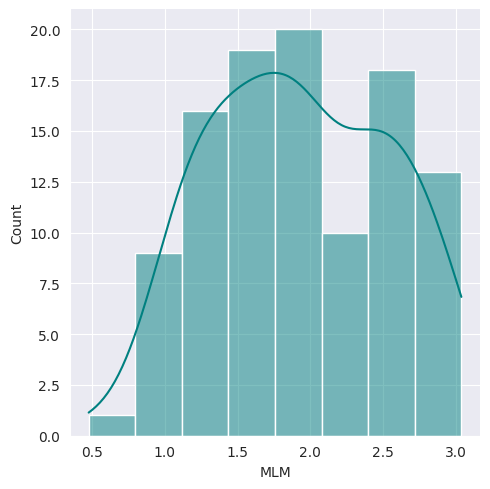

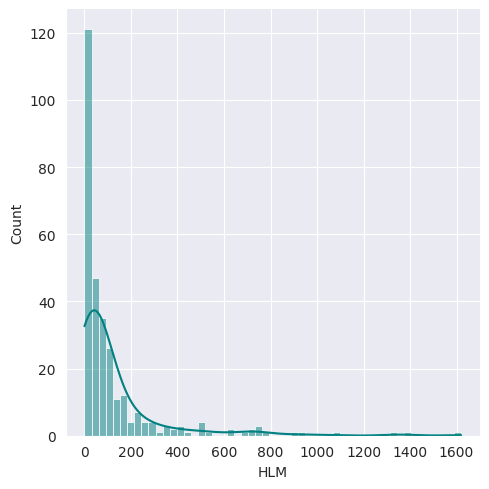

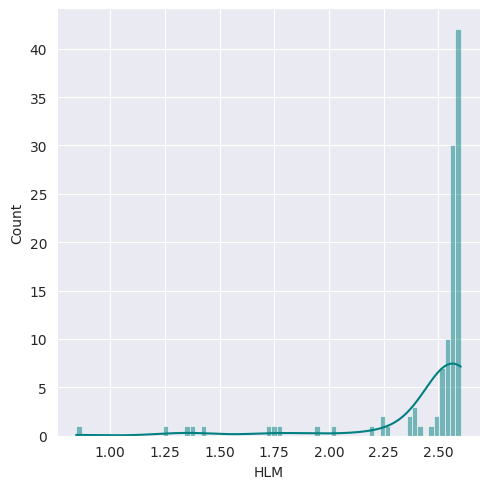

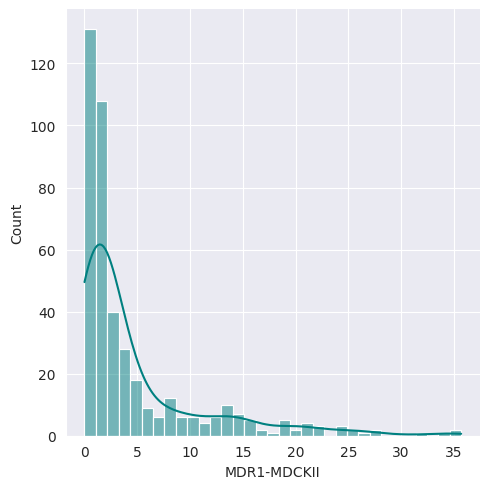

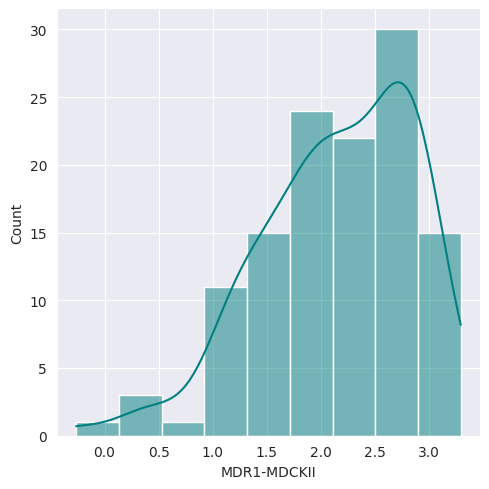

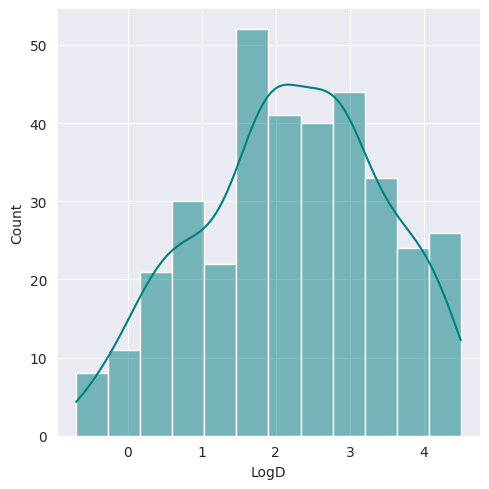

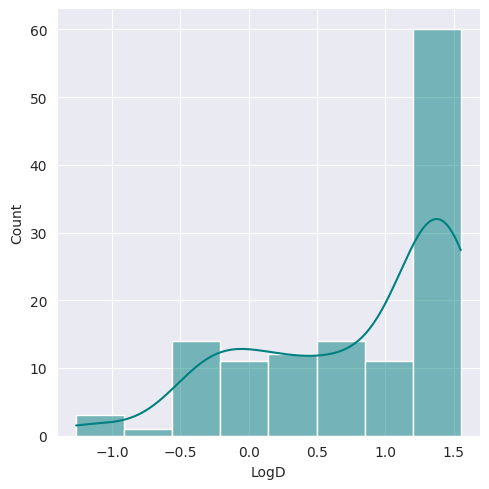

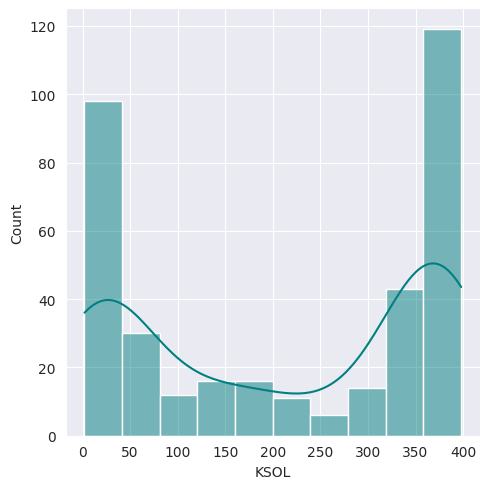

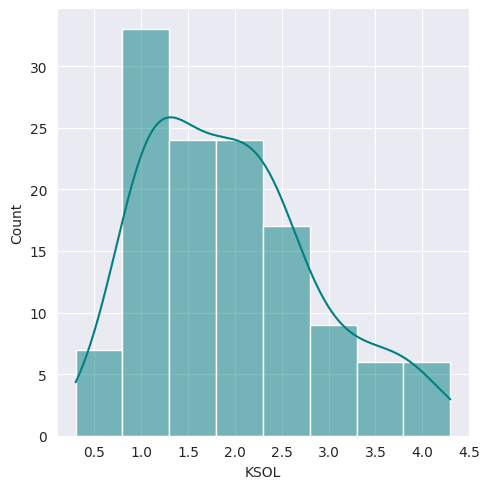

In [5]:
for tgt in tgts:
    train_dataset = train_datasets[tgt]
    y_values = [data.y.item() for data in train_dataset]
    sns.displot(data=pd.DataFrame({tgt: y_values}),
            x=tgt, kde=True, color='teal')

    test_dataset = test_datasets[tgt]
    y_values = [data.y.item() for data in test_dataset]
    sns.displot(data=pd.DataFrame({tgt: y_values}),
            x=tgt, kde=True, color='teal')
plt.show()

In [6]:
print(train_datasets["MLM"][0].ecfp)

tensor([0., 1., 1.,  ..., 0., 0., 0.])


In [7]:
def tanimoto_similarity(a, b):
    a = a.bool()
    b = b.bool()
    intersection = torch.sum(a & b).item()
    union = torch.sum(a | b).item()
    return intersection / union if union != 0 else 0.0

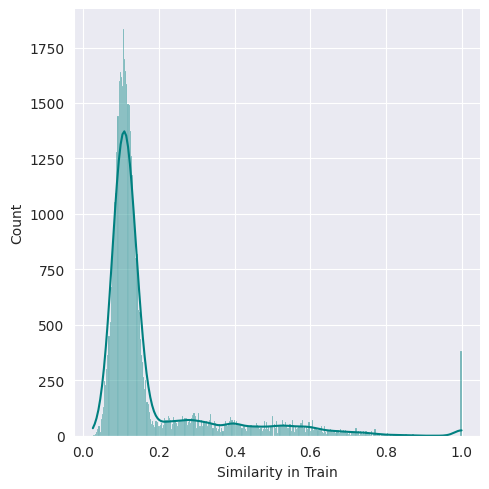

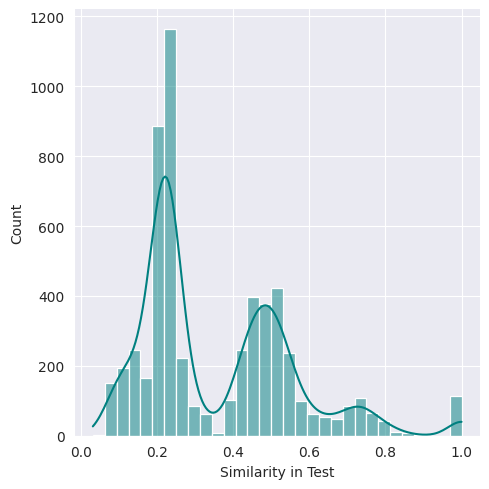

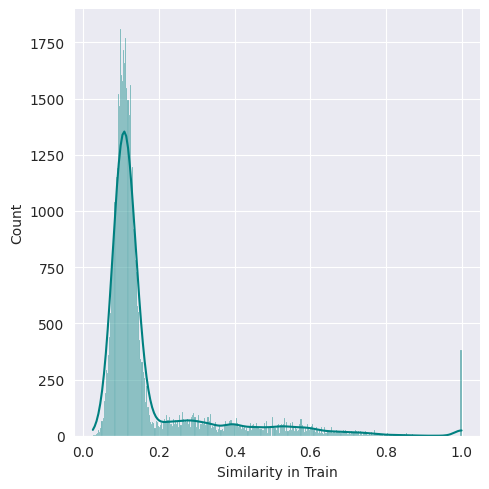

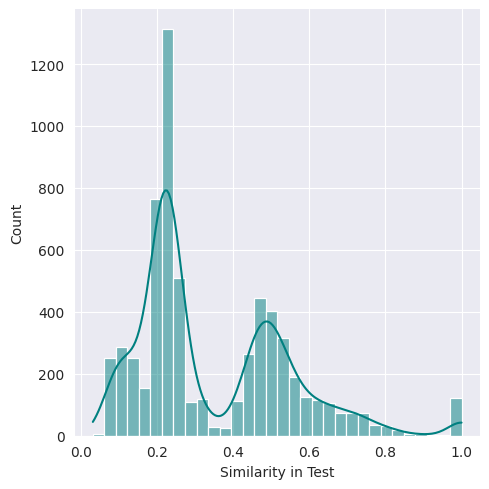

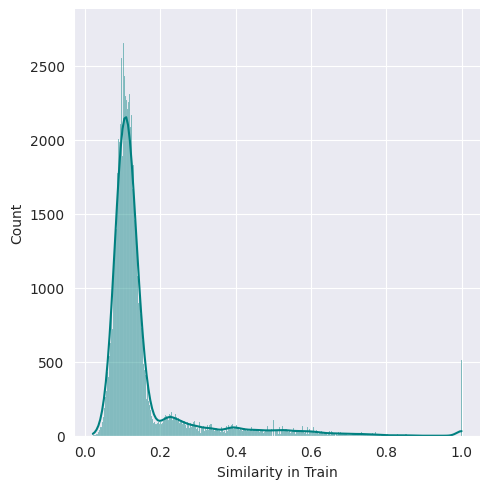

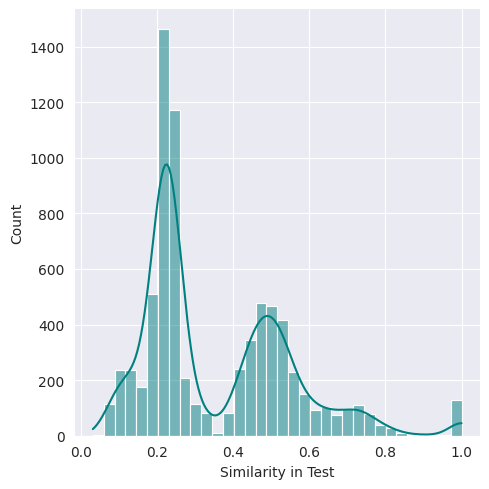

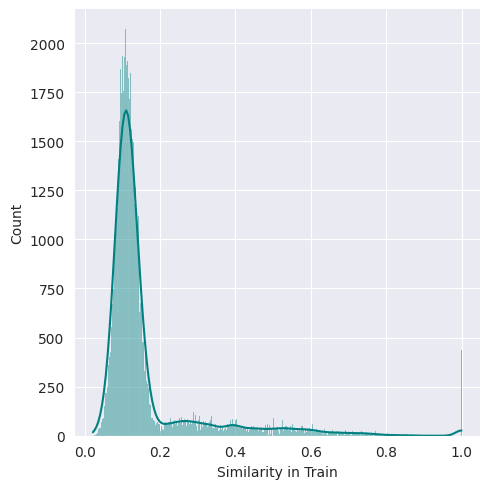

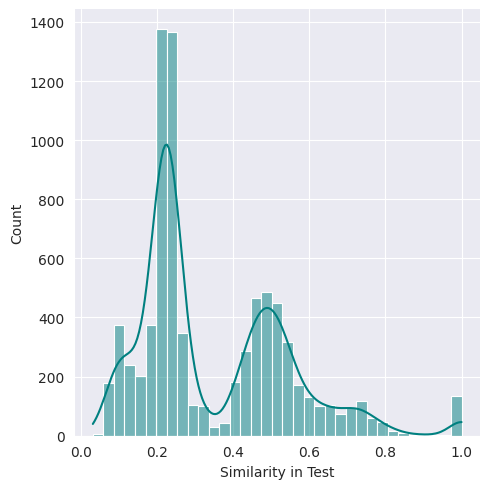

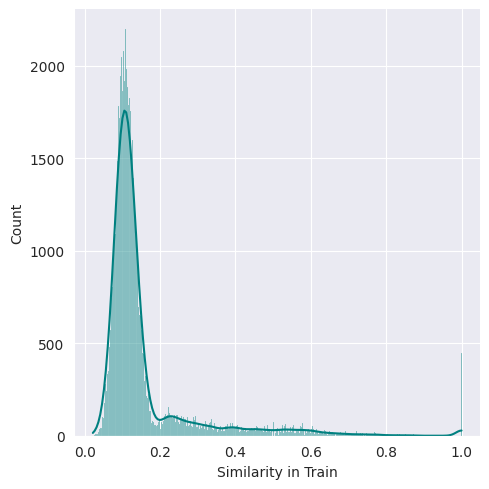

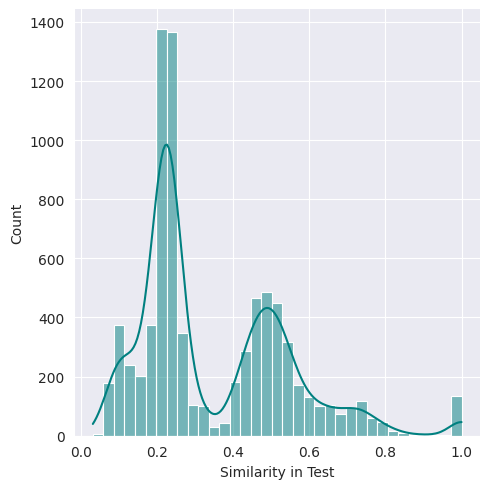

In [8]:
for tgt in tgts:
    train_dataset = train_datasets[tgt]
    sim = []
    for i in range(len(train_dataset) - 1):
        for j in range(i, len(train_dataset)):
            sim.append(tanimoto_similarity(train_dataset[i].ecfp, train_dataset[j].ecfp))
    sns.displot(data=pd.DataFrame({"Similarity in Train": sim}),
            x="Similarity in Train", kde=True, color='teal')

    test_dataset = test_datasets[tgt]
    sim = []
    for i in range(len(test_dataset) - 1):
        for j in range(i, len(test_dataset)):
            sim.append(tanimoto_similarity(test_dataset[i].ecfp, test_dataset[j].ecfp))
    sns.displot(data=pd.DataFrame({"Similarity in Test": sim}),
            x="Similarity in Test", kde=True, color='teal')
plt.show()

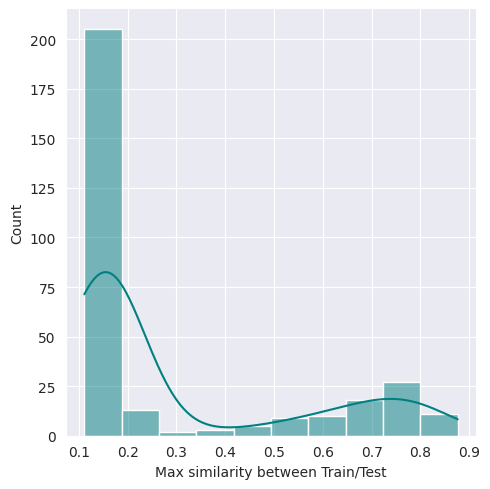

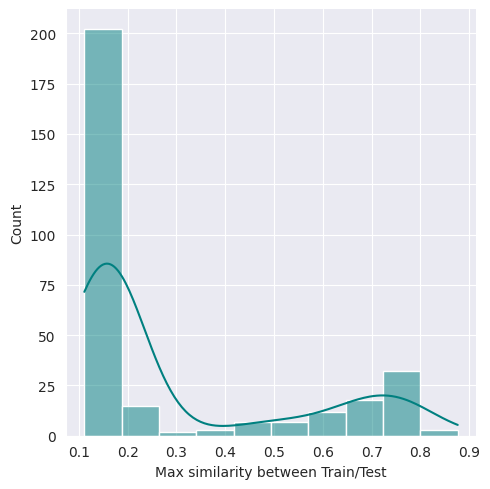

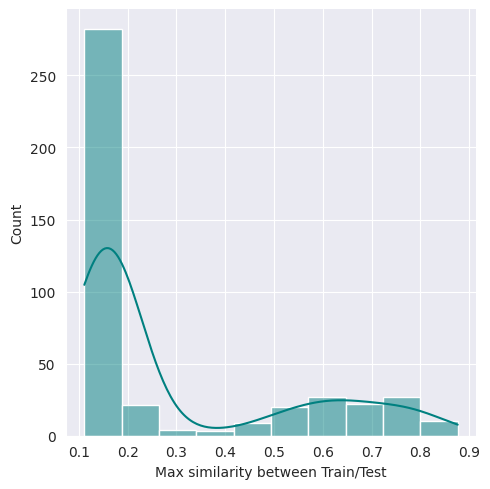

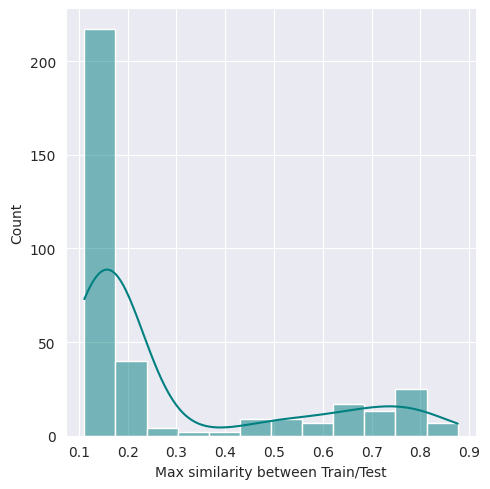

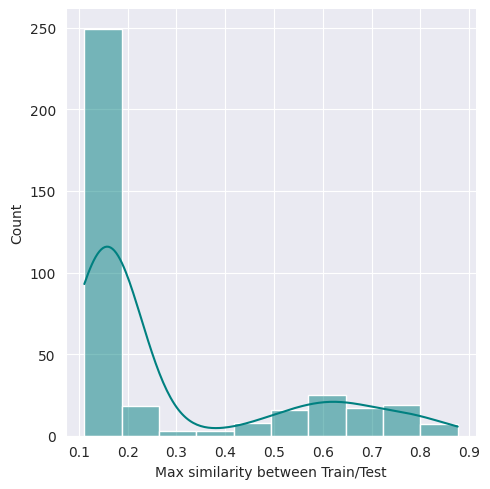

In [9]:
for tgt in tgts:
    train_dataset = train_datasets[tgt]
    test_dataset = test_datasets[tgt]
    sim = []
    for i in range(len(train_dataset)):
        max = 0
        for j in range(len(test_dataset)):
            simi = tanimoto_similarity(train_dataset[i].ecfp, test_dataset[j].ecfp)
            if simi > max:
                max = simi
        sim.append(max)
    sns.displot(data=pd.DataFrame({"Max similarity between Train/Test": sim}),
            x="Max similarity between Train/Test", kde=True, color='teal')

plt.show()

In [38]:
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

for tgt in tgts:
    print("Target ",tgt)
    train_dataset = train_datasets[tgt]
    y_values_train = [data.y.item() for data in train_dataset]
    test_dataset = test_datasets[tgt]
    y_values_test = [data.y.item() for data in test_dataset]
    print("Wasserstein distance:", wasserstein_distance(y_values_train, y_values_test))

    stat, p_value = ks_2samp(y_values_train, y_values_test)
    print("KS statistic (0= same - 1=disjoint):", stat)

Target  MLM
Wasserstein distance: 174.97515609763454
KS statistic (0= same - 1=disjoint): 0.9504950495049505
Target  HLM
Wasserstein distance: 121.80848951694674
KS statistic (0= same - 1=disjoint): 0.973421926910299
Target  MDR1-MDCKII
Wasserstein distance: 3.200289402588063
KS statistic (0= same - 1=disjoint): 0.34352941176470586
Target  LogD
Wasserstein distance: 1.4099734776650326
KS statistic (0= same - 1=disjoint): 0.7159090909090909
Target  KSOL
Wasserstein distance: 210.7918504026486
KS statistic (0= same - 1=disjoint): 0.9622091759078061


In [41]:
# get mols from smiles
# most common scaffolds are the same for all targets
smiles_train = [x["smiles"] for x in train_datasets["MLM"]]
mols_train = [Chem.MolFromSmiles(smiles_train[i]) for i in range(len(smiles_train))]
scaffold_smiles = [Chem.MolToSmiles(GetScaffoldForMol(x)) for x in mols_train]
scaffold_counts= Counter(scaffold_smiles)

mols = [Chem.MolFromSmiles(x[0]) for x in scaffold_counts.most_common(6)]
img = Draw.MolsToImage(mols, molsPerRow=3, subImgSize=(200,200))
img.show()

In [ ]:
smiles_test = [x["smiles"] for x in test_datasets[tgt]]
mols_test = [Chem.MolFromSmiles(smiles_test[i]) for i in range(len(smiles_test))]
scaffold_smiles = [Chem.MolToSmiles(GetScaffoldForMol(x)) for x in mols_test]
scaffold_counts= Counter(scaffold_smiles)

mols = [Chem.MolFromSmiles(x[0]) for x in scaffold_counts.most_common(6)]
img = Draw.MolsToImage(mols, molsPerRow=3, subImgSize=(200,200))
img.show()

In [40]:


# get mols from smiles
for tgt in tgts: # most common scaffolds are the same for all targets
    smiles_train = [x["smiles"] for x in train_datasets[tgt]]
    mols_train = [Chem.MolFromSmiles(smiles_train[i]) for i in range(len(smiles_train))]
    scaffold_smiles = [Chem.MolToSmiles(GetScaffoldForMol(x)) for x in mols_train]
    scaffold_counts= Counter(scaffold_smiles)


    smiles_test = [x["smiles"] for x in test_datasets[tgt]]
    mols_test = [Chem.MolFromSmiles(smiles_test[i]) for i in range(len(smiles_test))]
    scaffold_smiles = [Chem.MolToSmiles(GetScaffoldForMol(x)) for x in mols_test]
    scaffold_counts= Counter(scaffold_smiles)


In [ ]:
# get mols from smiles
smiles_train = [smiles[0] for smiles in train]
mols_train = [Chem.MolFromSmiles(smiles_train[i]) for i in range(len(smiles_train))]


smiles_test = test
mols_test = [Chem.MolFromSmiles(smiles_test[i]) for i in range(len(smiles_test))]

In [ ]:
# draw some molecules for each target for each category (min, avg, max)
# Draw.MolsToGridImage(mols_test, molsPerRow=3, subImgSize=(300, 300))

#for tgt in train.target_cols: # why doesn't it print those, if I loop it :(
tgt = "MLM" #['MLM', 'HLM', 'MDR1-MDCKII', 'LogD', 'KSOL']
y = train.y[tgt]
mask = ~np.isnan(y)
min = np.min(y[mask])

min_indices = np.where(y == min)[0]
mols = [mols_train[i] for i in min_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

In [ ]:
max = np.max(y[mask])

max_indices = np.where(y == max)[0]
mols = [mols_train[i] for i in max_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

In [ ]:
avg = np.average(y[mask])

avg_indices = [0] # todo: find avg indices
mols = [mols_train[i] for i in avg_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))